In [1]:
import json
import pandas as pd
import numpy as np
from pprint import pprint

from src.constants import FIGS_DIR
from src.experiments import load_interleaver
from src.utils import DEFAULT_DEVICE_MANAGER, DeviceManager
from src.graphs import nonrecursive_turbo_graph

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LogLocator, LogFormatter, FixedLocator
from matplotlib import cm


class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

# Decomposition Evolution

In [31]:
import numpy as np

def make_results_df(filepaths):
    data = []
    for filepath in filepaths:
        with open(filepath, "r") as f:
            exp_dict = json.load(f)
        data += exp_dict["data"]

    results_df = []
    for datum in data:
        results_df+= [{**r, "snr": datum["preamble"]["args"]["snr"]} for r in datum["results"]]

    results_df = pd.DataFrame(results_df)
    return results_df

# filepaths = ["../data/outputs/decomposition_trajectory_turboae_40.json", "../data/outputs/decomposition_trajectory_turboae_40_high_snr.json"]
filepaths = ["../data/outputs/decomposition_trajectory_turboae_40_2.json"]

decomp_results_df = make_results_df(filepaths)
decomp_results_df.head()

,basename,epoch,datetime,filepath,avg_time,true_xe__mean,true_ber__mean,true_bler__mean,approx_xe__mean,approx_ber__mean,...,true_ber__err,true_bler__err,approx_xe__err,approx_ber__err,approx_bler__err,kl__err,modulated_power__err,modulated_mean__err,num_samples,snr
0,turboae_trainer,0,2023_05_10_09_12_26,../checkpoints/turboae_trainer_ep0_2023_05_10_...,0.000000,0.150255,0.067500,0.933333,0.695651,0.514167,...,0.015748,0.092641,0.002123,0.029912,0.000000,0.030148,0.043037,0.015784,30,0.0
1,turboae_trainer,8,2023_05_10_09_15_38,../checkpoints/turboae_trainer_ep8_2023_05_10_...,1.344437,0.119218,0.046669,0.849444,0.118930,0.046153,...,0.000713,0.007540,0.001411,0.000710,0.007601,0.000375,0.000901,0.002218,9000,0.0
2,turboae_trainer,16,2023_05_10_09_18_50,../checkpoints/turboae_trainer_ep16_2023_05_10...,183.670156,0.115444,0.044658,0.833222,0.112352,0.043006,...,0.000704,0.007859,0.001455,0.000685,0.008039,0.000419,0.000580,0.001736,9000,0.0
3,turboae_trainer,24,2023_05_10_09_22_03,../checkpoints/turboae_trainer_ep24_2023_05_10...,245.309716,0.127844,0.050294,0.867444,0.109504,0.041786,...,0.000735,0.007149,0.001403,0.000675,0.008239,0.000714,0.000348,0.001359,9000,0.0
4,turboae_trainer,32,2023_05_10_09_25_16,../checkpoints/turboae_trainer_ep32_2023_05_10...,276.245326,0.136713,0.053886,0.891778,0.106938,0.041403,...,0.000756,0.006550,0.001372,0.000672,0.008256,0.000894,0.000258,0.001268,9000,0.0


In [32]:
def make_tae_finetune_decomp_def(filepaths):
    data = []
    for filepath in filepaths:
        with open(filepath, "r") as f:
            exp_dict = json.load(f)
        data += exp_dict["data"]

    results_df = []
    for datum in data:
        results_df.append({**datum["results"], "snr": datum["preamble"]["args"]["snr"], "turboae_type": datum["preamble"]["args"]["turboae_type"]})
    
    results_df = pd.DataFrame(results_df)
    return results_df

filepaths = ["../data/outputs/decomposition_turboae_finetune_40.json"]

decomp_finetune_df = make_tae_finetune_decomp_def(filepaths)
decomp_finetune_df
        

,true_xe__mean,true_ber__mean,true_bler__mean,approx_xe__mean,approx_ber__mean,approx_bler__mean,kl__mean,modulated_power__mean,modulated_mean__mean,true_xe__std,...,true_bler__err,approx_xe__err,approx_ber__err,approx_bler__err,kl__err,modulated_power__err,modulated_mean__err,num_samples,snr,turboae_type
0,0.012197,0.004489,0.051535,0.043730,0.018425,0.118021,0.031533,1.000000,-0.024592,0.070766,...,0.002657,0.001751,0.000846,0.003878,0.001576,0.000000,0.001164,27690,0.0,binary
1,0.001695,0.000586,0.010567,0.006731,0.002578,0.022300,0.005036,1.000000,-0.023247,0.019953,...,0.001181,0.000620,0.000291,0.001705,0.000575,0.000000,0.001125,30000,1.0,binary
2,0.000214,0.000063,0.001933,0.000598,0.000184,0.002867,0.000384,1.000000,-0.024004,0.004773,...,0.000507,0.000147,0.000066,0.000617,0.000143,0.000000,0.001113,30000,2.0,binary
3,0.014825,0.005492,0.055382,0.055892,0.024615,0.138265,0.041067,0.999952,-0.000650,0.080164,...,0.003150,0.002282,0.001146,0.004754,0.002053,0.000689,0.001263,21090,0.0,continuous
4,0.002039,0.000689,0.011767,0.009832,0.004000,0.028533,0.007793,0.999597,0.000865,0.029343,...,0.001245,0.000833,0.000387,0.001923,0.000794,0.000579,0.001065,30000,1.0,continuous
5,0.000249,0.000088,0.002000,0.000999,0.000358,0.003700,0.000750,0.999790,0.000077,0.006493,...,0.000516,0.000224,0.000104,0.000701,0.000216,0.000577,0.001057,30000,2.0,continuous


In [33]:
filepaths = [
    "../data/outputs/xe_trajectory_turboae_40.json"
]

xe_results_df = make_results_df(filepaths)
xe_results_df.head()

,basename,epoch,datetime,filepath,avg_time,xe__mean,ber__mean,bler__mean,modulated_power__mean,modulated_mean__mean,...,bler__std,modulated_power__std,modulated_mean__std,xe__err,ber__err,bler__err,modulated_power__err,modulated_mean__err,num_samples,snr
0,turboae_trainer,0,2023_05_07_01_31_12,../checkpoints/turboae_trainer_ep0_2023_05_07_...,0.000000,0.692814,0.499799,1.000000,1.000048,-0.000297,...,0.000000,0.125805,0.147570,0.000042,0.000598,0.000000,0.000951,0.001116,70000,0.0
1,turboae_trainer,8,2023_05_07_01_34_23,../checkpoints/turboae_trainer_ep8_2023_05_07_...,3.729153,0.121878,0.047547,0.856300,0.999951,-0.000167,...,0.350788,0.039566,0.099523,0.000529,0.000256,0.002652,0.000299,0.000752,70000,0.0
2,turboae_trainer,16,2023_05_07_01_37_35,../checkpoints/turboae_trainer_ep16_2023_05_07...,3.723072,0.130882,0.051048,0.876114,0.999846,-0.000968,...,0.329453,0.024864,0.118257,0.000546,0.000263,0.002490,0.000188,0.000894,70000,0.0
3,turboae_trainer,24,2023_05_07_01_40_48,../checkpoints/turboae_trainer_ep24_2023_05_07...,3.730358,0.137065,0.053917,0.890500,1.000075,0.000697,...,0.312268,0.025266,0.111854,0.000531,0.000271,0.002361,0.000191,0.000846,70000,0.0
4,turboae_trainer,32,2023_05_07_01_44_01,../checkpoints/turboae_trainer_ep32_2023_05_07...,3.733817,0.142426,0.056050,0.899871,1.000123,0.000449,...,0.300174,0.026942,0.107808,0.000526,0.000275,0.002269,0.000204,0.000815,70000,0.0


[Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(0, 0.001, '$\\mathdefault{10^{-3}}$'), Text(0, 0.01, '$\\mathdefault{10^{-2}}$'), Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), Text(0, 1.0, '$\\mathdefault{10^{0}}$'), Text(0, 10.0, '$\\mathdefault{10^{1}}$'), Text(0, 100.0, '$\\mathdefault{10^{2}}$')]


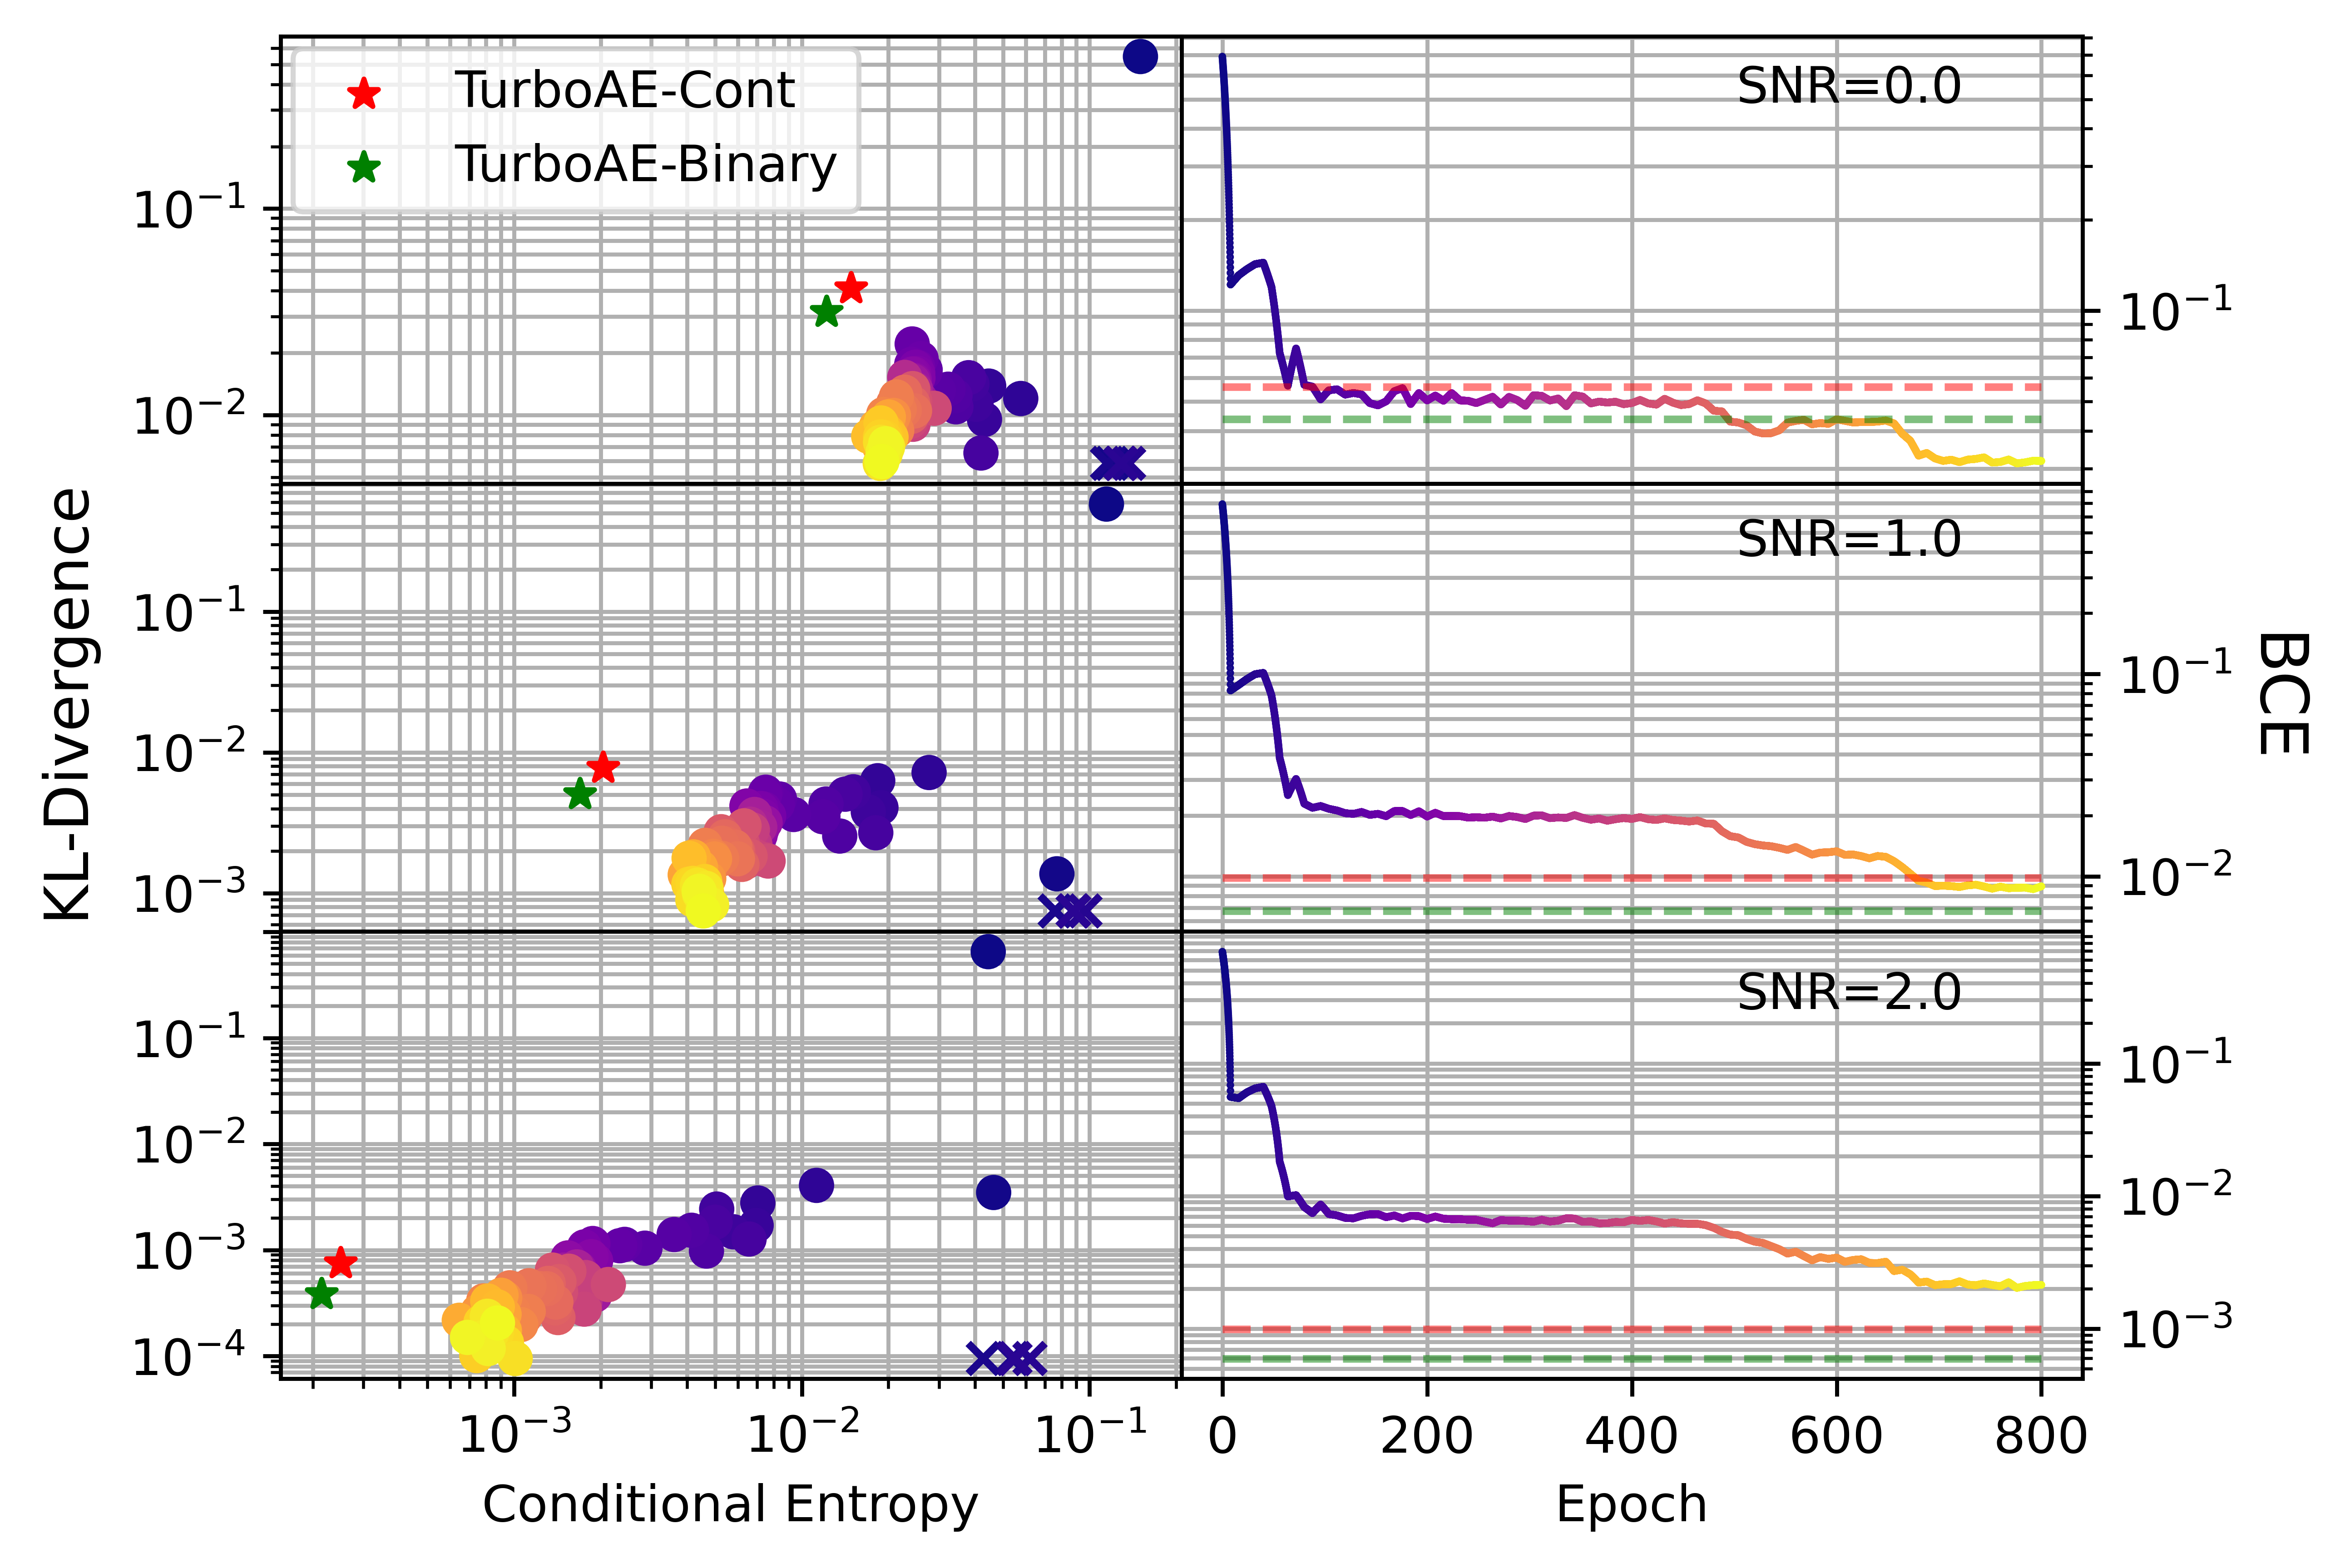

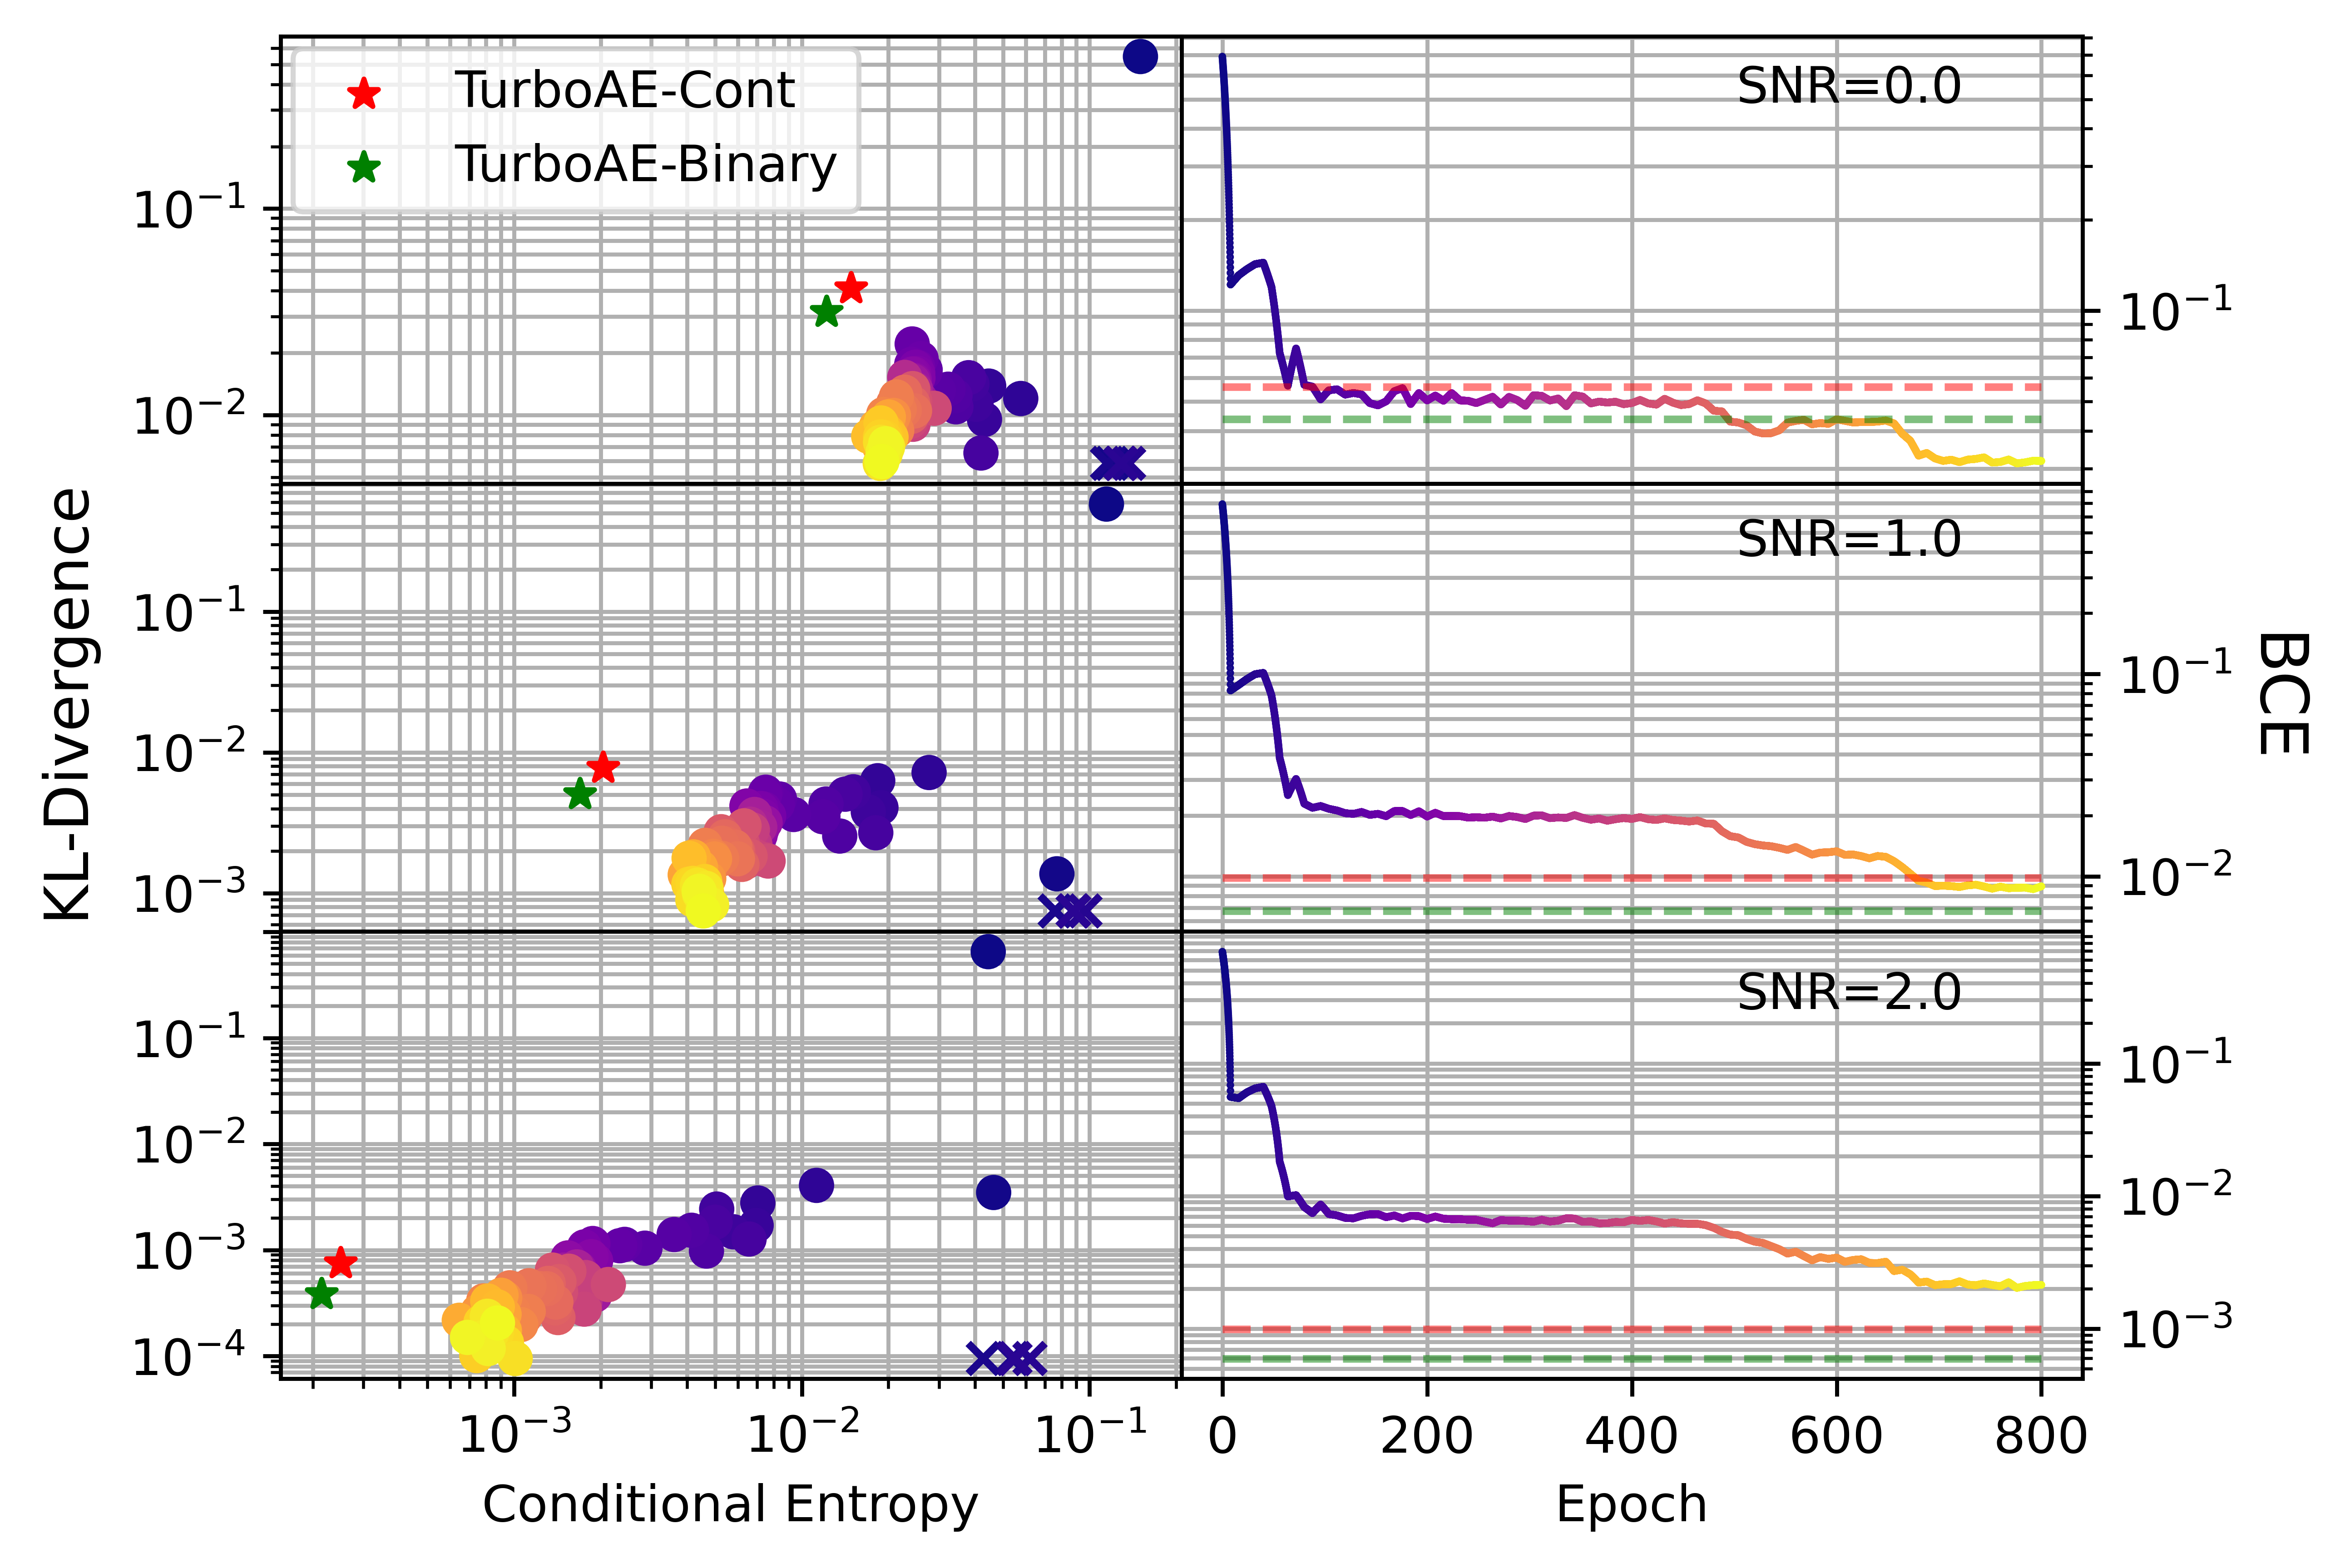

In [36]:



def make_trajectory(
    decomp_df: pd.DataFrame, xe_df: pd.DataFrame, tae_finetune_df: pd.DataFrame
):
    snrs = decomp_df["snr"].unique()
    # print(snrs)

    ncols = 2
    nrows = len(snrs)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex="col", dpi=800)
    fig.supylabel("KL-Divergence", x=0.02)
    fig.text(x=0.95, y=0.5, s="BCE\n\n", size=13, rotation=270, ha="center", va="center")
    fig.text(x=0.8, y=0.85, s="SNR=0.0", size=10, rotation=0, ha="center", va="center")
    fig.text(x=0.8, y=0.59, s="SNR=1.0", size=10, rotation=0, ha="center", va="center")
    fig.text(x=0.8, y=0.33, s="SNR=2.0", size=10, rotation=0, ha="center", va="center")
    # fig.supxlabel("Fourier Coefficient/Parity Index (0 through 32)", fontsize=SMALL_SIZE, y=0.04)
    fig.subplots_adjust(wspace=0, hspace=0)
    # ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width

    # Column 1
    for snr_i in range(nrows):
        ax_sub = axs[snr_i, 0]
        make_decomposition_plot(
            ax_sub,
            decomp_df[decomp_df["snr"] == snrs[snr_i]],
            tae_finetune_df[tae_finetune_df["snr"] == snrs[snr_i]],
            show_legend=(snr_i == 0),
        )
    # axs[0, 0].annotate("", xy=(0.5, 0.5), xytext=(0, 0),
            # arrowprops=dict(arrowstyle="->"))
    # axs[0,0].arrow(0, 0, 0.25, 0.25)
    
    # axs[2, 0].set_yticklabels([1e-1, 1e-2, 1e-3, 1e-4])
    t = axs[2, 0].yaxis.get_ticklabels()
    print(t)
    t[6].set_visible(False)

    # Column 2
    for snr_i in range(nrows):
        ax_sub = axs[snr_i, 1]
        make_xe_plot(
            ax_sub,
            xe_df[xe_df["snr"] == snrs[snr_i]],
            tae_finetune_df[tae_finetune_df["snr"] == snrs[snr_i]],
        )

    return fig


def make_decomposition_plot(
    ax, df: pd.DataFrame, tae_finetune_df: pd.DataFrame, show_legend=False
):
    # ax = fig.add_axes([0.1, 0.1, .9, .9])  # Last two terms control height and width

    cmap_helper = MplColorHelper(
        "plasma", start_val=df["epoch"].min(), stop_val=df["epoch"].max()
    )
    c = np.array(cmap_helper.get_rgb(df["epoch"]))
    # display(df.reset_index().loc[:20, ["epoch", "kl__mean", "true_xe__mean"]])

    kl = df["kl__mean"]
    cond_ent = df["true_xe__mean"]
    # Non-negative values
    filter = df["kl__mean"] > 0
    ax.scatter(cond_ent[filter], kl[filter], c=c[filter.values])
    ax.scatter(
        cond_ent[~filter],
        np.full_like(cond_ent[~filter].values, fill_value=kl[filter].min()),
        c=c[~filter.values],
        marker="x",
    )

    # Finetune
    # Continuous
    cont_df = tae_finetune_df[tae_finetune_df["turboae_type"] == "continuous"]
    ax.scatter(
        cont_df["true_xe__mean"],
        cont_df["kl__mean"],
        c="red",
        marker="*",
        label="TurboAE-Cont",
    )
    # Binary
    bin_df = tae_finetune_df[tae_finetune_df["turboae_type"] == "binary"]
    ax.scatter(
        bin_df["true_xe__mean"],
        bin_df["kl__mean"],
        c="green",
        marker="*",
        label="TurboAE-Binary",
    )

    if show_legend:
        # ax.legend(bbox_to_anchor=[0.69, 1.0])
        # ax.legend(loc='upper left', borderaxespad=0.02)
        ax.legend(loc='upper left', borderaxespad=0.25)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Conditional Entropy")
    
    locmaj = LogLocator(base=10, numticks=100)
    locmin = LogLocator(base=10, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=100)
    ax.yaxis.set_major_locator(locmaj)
    ax.minorticks_on()
    ax.yaxis.set_minor_locator(locmin)
    ax.grid(visible=True, which="both")  
    ax.set_axisbelow(True)  
    # ax.set_ylabel('KL Divergence')
    # ax.set_title("Evolution of BCE Decomposition at SNR 0.0")


def make_xe_plot(ax, df: pd.DataFrame, tae_df: pd.DataFrame):

    df_ep_xe = df[["epoch", "xe__mean"]].set_index("epoch")
    last_ep = df["epoch"].max()
    ep_resample = np.linspace(0, last_ep, 10000)
    df_ep_xe = df_ep_xe \
        .reindex(df_ep_xe.index.union(ep_resample)) \
        .interpolate(method="index")
    
    cmap_helper = MplColorHelper(
        "plasma", start_val=df["epoch"].min(), stop_val=df["epoch"].max()
    )
    c = np.array(cmap_helper.get_rgb(df_ep_xe.index))
    
    # ax.plot(
    #     df["epoch"],
    #     df["xe__mean"],
    #     linestyle="-",
    # )
    
    ax.scatter(df_ep_xe.index, df_ep_xe["xe__mean"], c=c, marker=".", s=1)

    num_samples = len(df["epoch"])
    cont_df = tae_df[tae_df["turboae_type"] == "continuous"]
    cont_xe_mean = cont_df["approx_xe__mean"].values[0]
    ax.plot(
        df["epoch"],
        np.full((num_samples,), cont_xe_mean),
        linestyle="--",
        alpha=0.5,
        c="red"
    )

    bin_df = tae_df[tae_df["turboae_type"] == "binary"]
    bin_xe_mean = bin_df["approx_xe__mean"].values[0]
    ax.plot(
        df["epoch"],
        np.full((num_samples,), bin_xe_mean),
        linestyle="--",
        alpha=0.5,
        c="green"
    )

    ax.grid(visible=True, which="both")
    ax.set_axisbelow(True)
    ax.set_yscale("log")
    ax.yaxis.tick_right()
    ax.set_xlabel("Epoch")


# fig = make_decomposition_plot(results)

fig = make_trajectory(decomp_results_df, xe_results_df, decomp_finetune_df)
fig.savefig(FIGS_DIR / "decomposition_evolution.png", bbox_inches="tight", pad_inches=0.02)
fig


# Cluster Tree Statistics

In [111]:
import numpy as np
from collections.abc import Iterable

filepath = "../data/outputs/cluster_tree_statistics_istc.json"

with open(filepath, "r") as f:
    exp_dict = json.load(f)

results = [{**result, **exp_info["preamble"]["args"], "argument_hash": exp_info["preamble"]["argument_hash"]} for exp_info in exp_dict["data"] for result in exp_info["results"]]
# Correct bug where I accidentally included all factor sizes, not just largest.
for result in results:
    fw = result["factor_width"]
    if isinstance(fw, Iterable):
        result["factor_width"] = max(fw)

results = pd.DataFrame(results)
print(len(results))
results.head()

528


,factor_width,interleaver_seed,elimination_seed,type,experiment_id,interleaver_base_seed,block_len,window,delay,num_samples,argument_hash
0,6,56976,67841,trial,cluster_tree_statistics_istc,1049184,10,3,1,10,5e65767d884719f67557beeac1a179fea3981aeb
1,6,2812,75465,trial,cluster_tree_statistics_istc,1049184,10,3,1,10,5e65767d884719f67557beeac1a179fea3981aeb
2,7,6358,79799,trial,cluster_tree_statistics_istc,1049184,10,3,1,10,5e65767d884719f67557beeac1a179fea3981aeb
3,6,70638,54924,trial,cluster_tree_statistics_istc,1049184,10,3,1,10,5e65767d884719f67557beeac1a179fea3981aeb
4,5,6983,82285,trial,cluster_tree_statistics_istc,1049184,10,3,1,10,5e65767d884719f67557beeac1a179fea3981aeb


[Text(0, 0.0, '0'), Text(0, 10.0, '10'), Text(0, 20.0, '20'), Text(0, 30.0, '30'), Text(0, 40.0, '40'), Text(0, 50.0, '50'), Text(0, 60.0, '60'), Text(0, 70.0, '70'), Text(0, 80.0, '80'), Text(0, 90.0, '90')]
[Text(10, 0, '10'), Text(20, 0, '20'), Text(30, 0, '30'), Text(40, 0, '40'), Text(50, 0, '50'), Text(60, 0, '60'), Text(70, 0, '70'), Text(80, 0, '80'), Text(90, 0, '90'), Text(100, 0, '100'), Text(125, 0, '125'), Text(150, 0, '150')]


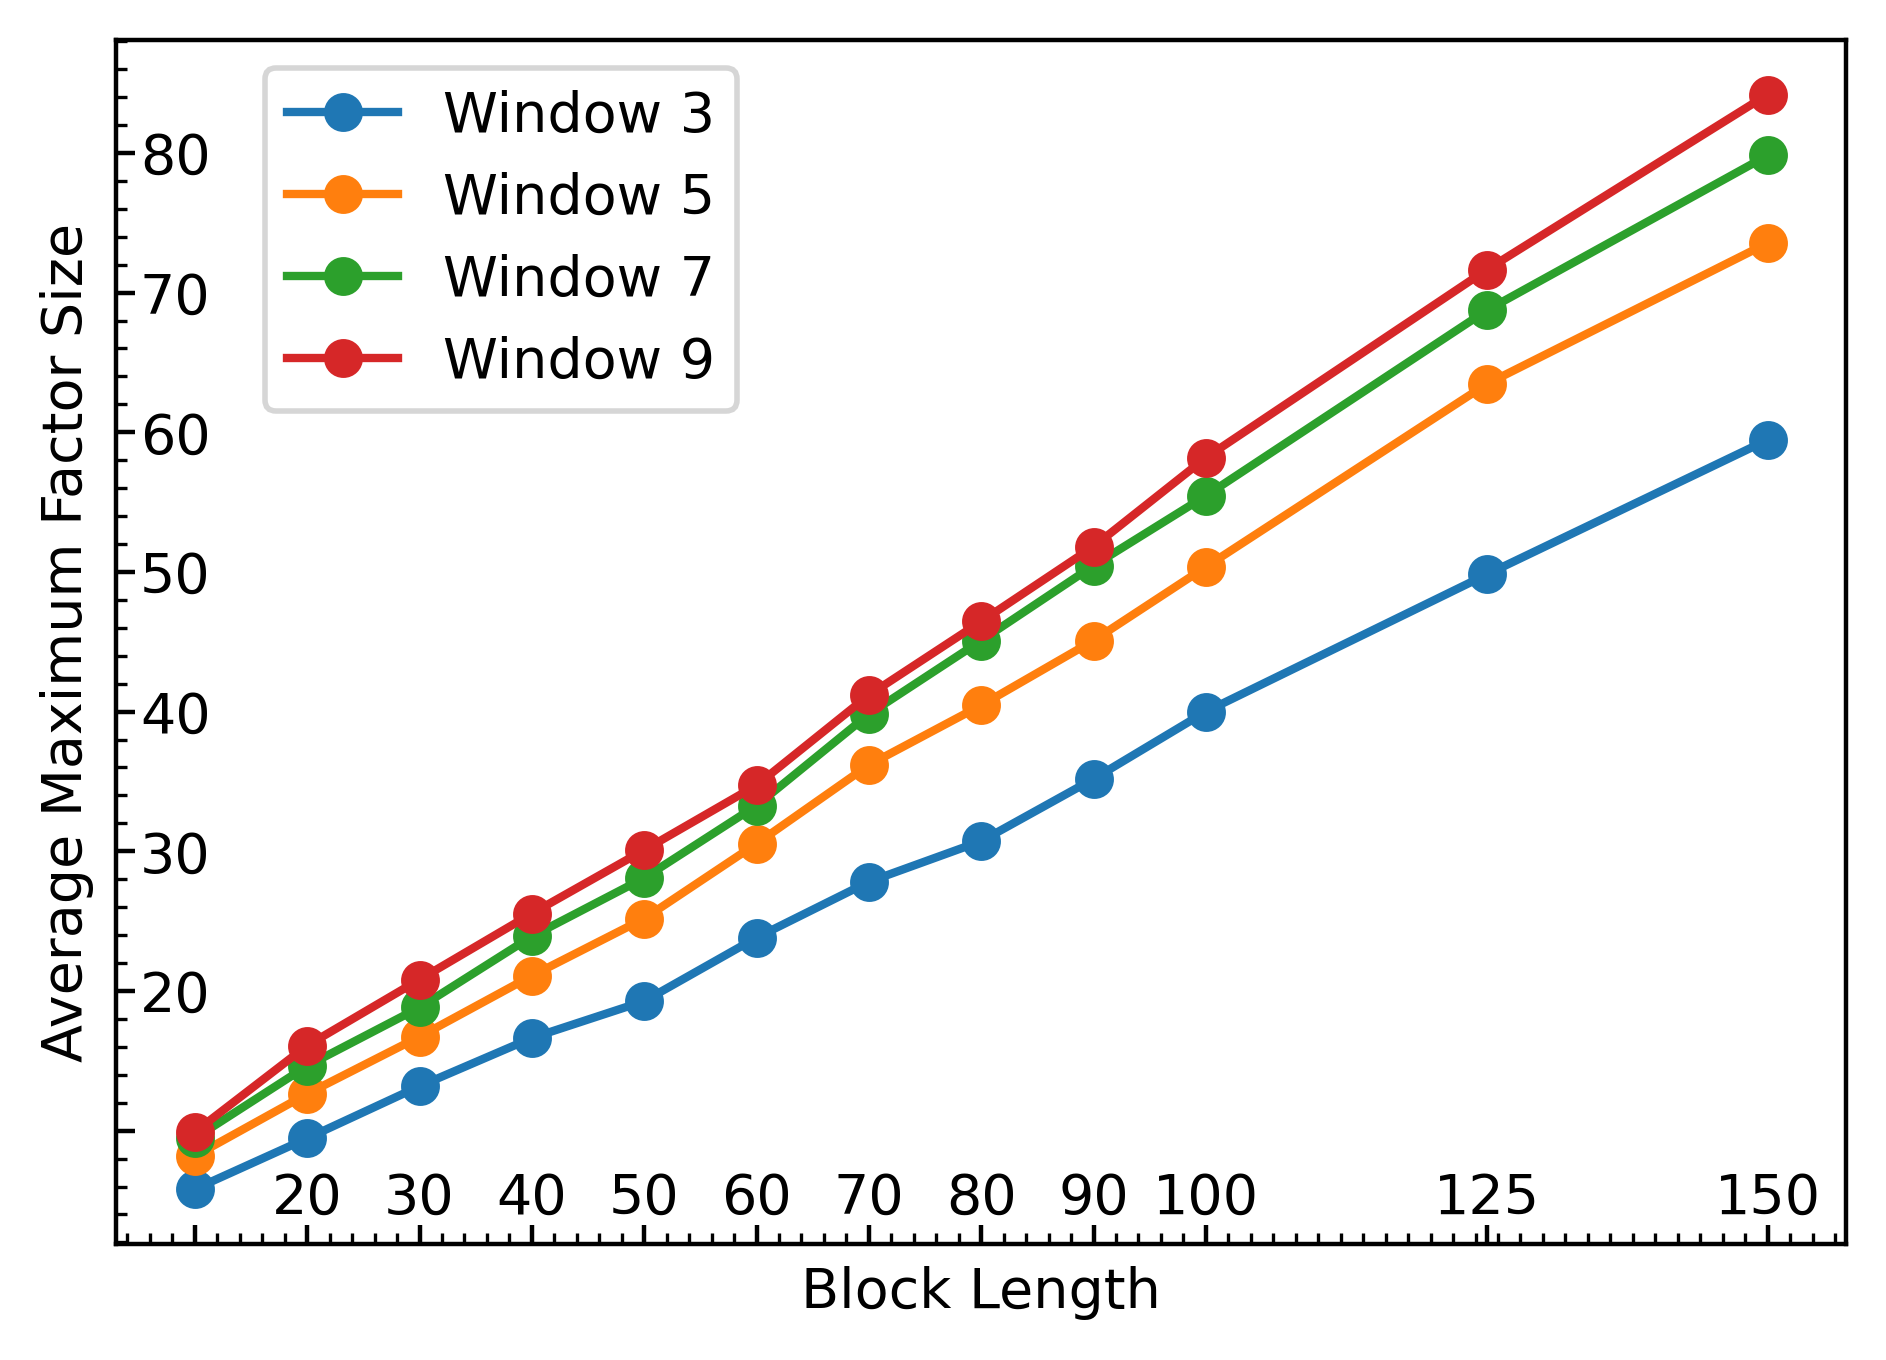

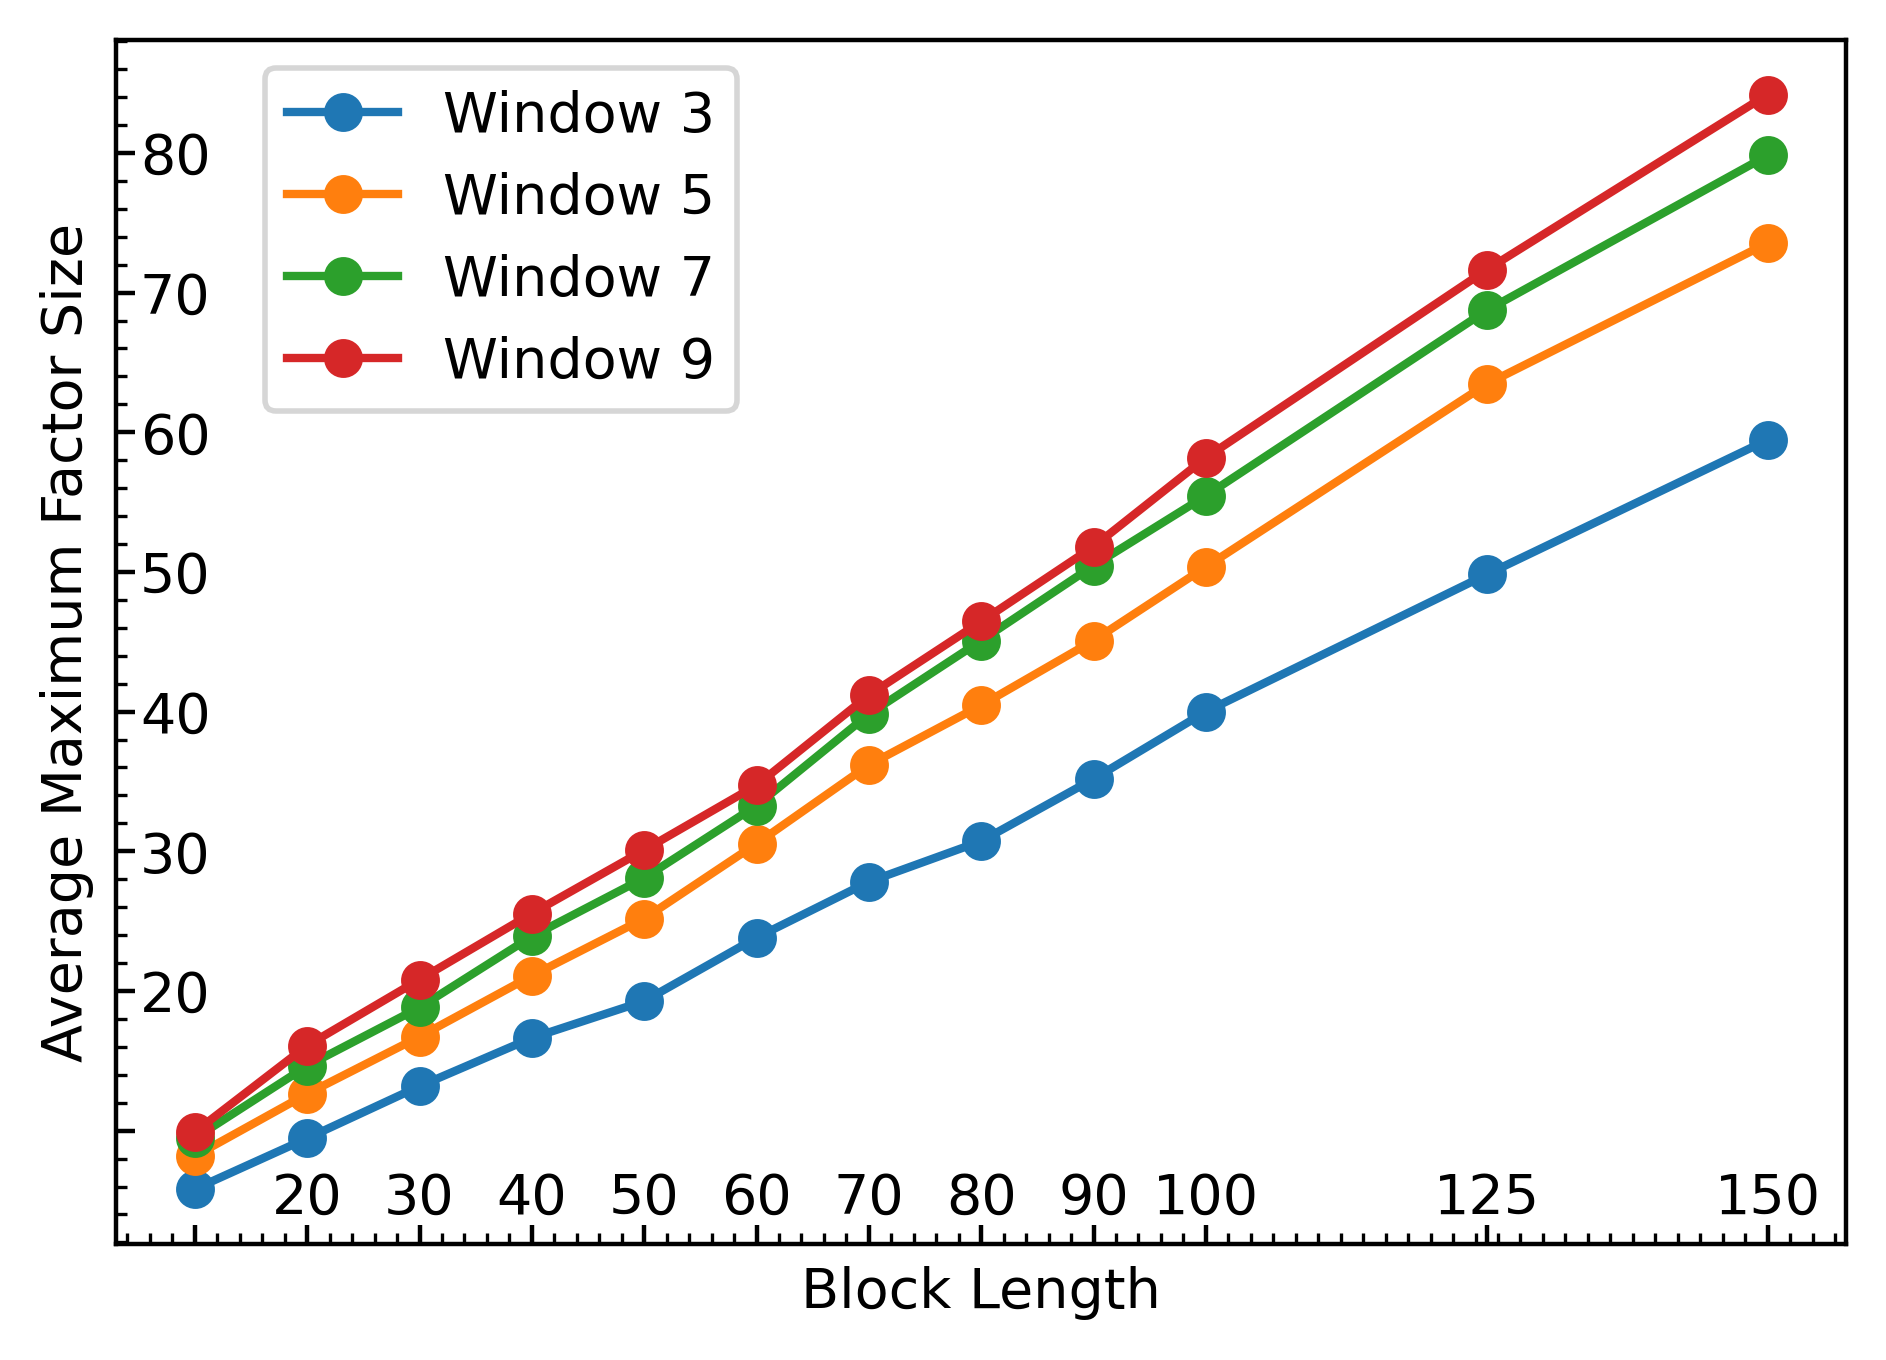

In [112]:
def make_factor_width_plot(df: pd.DataFrame):
    data = df.groupby(["block_len", "window"]).agg({"factor_width": "mean"}).reset_index(drop=False)
    
    
    # fig = plt.figure(figsize=(8, 6), dpi=400)
    # ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    fig = plt.figure(dpi=400, figsize=(5, 3.5))
    ax = fig.add_axes([0.13, 0.13, .865, .86])  # Last two terms control height and width
    
    for window, line_df in data.groupby("window"):
        ax.errorbar(
            x=line_df["block_len"],
            y=line_df["factor_width"],
            label=f"Window {window}",
            marker="o"
        )
    ax.legend(bbox_to_anchor=[0.375, 1.0])
    # ax.legend()
    ax.minorticks_on()
    ax.tick_params(axis="y", which="both", direction="in", pad=-17)
    ax.tick_params(axis="x", which="both", direction="in", pad=-13)
    ax.xaxis.set_major_locator(FixedLocator(locs=list(line_df["block_len"])))
    ax.set_xlabel('Block Length')
    ax.set_ylabel('Average Maximum Factor Size')
    # ax.set_title("Factor Sizes vs. Block Length for different window sizes")
    
    t = ax.yaxis.get_ticklabels()
    print(t)
    # Hide y=10
    t[1].set_visible(False)
    t2 = ax.xaxis.get_ticklabels()
    print(t2)
    # Hide x=10
    t2[0].set_visible(False)
    
    display(fig)
    return fig

fig = make_factor_width_plot(results)
fig.savefig(FIGS_DIR / "factor_sizes.png", bbox_inches="tight", pad_inches=0.02)

In [45]:
import networkx as nx

interleaver_base_seed = 56976
elimination_seed = 69783

window = 9
delay = (window - 1) - ((window - 1) // 2)
block_len = 40
print(f"Delay: {delay}")

interleaver = load_interleaver(
    interleaver_type="fixed",
    block_len=block_len,
    manager=DEFAULT_DEVICE_MANAGER,
    interleaver_base_seed=interleaver_base_seed,
)

nt_inference_graph = nonrecursive_turbo_graph(
    interleaver.permutation, window=window, delay=delay
).with_elimination_ordering(sample_thresh=3, tries=50, seed=elimination_seed)
main_nt_tree = nt_inference_graph.as_cluster_tree().graph


Delay: 4
69783


100%|██████████| 50/50 [00:07<00:00,  6.82it/s, best=23]


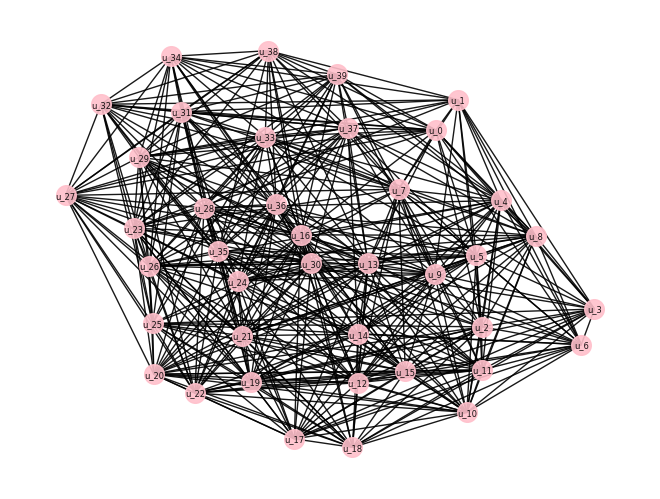

In [46]:
nt_graph = nt_inference_graph.graph
pos = nx.spring_layout(nt_graph)
nx.draw(nt_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=200, node_color='pink', alpha=0.9, labels={node: node for node in nt_graph.nodes()}, font_size=6)

In [47]:

# pos = nx.spring_layout(main_nt_tree)
# # node_labels = {node: nt_tree.nodes[node]["variables"] for node in nt_tree.nodes()}
# node_labels = {node: len(nt_tree.nodes[node]["variables"]) for node in nt_tree.nodes()}
# # edge_labels = {edge: nt_tree.edges[edge]["intersection"] for edge in nt_tree.edges()}
# edge_labels = {edge: len(nt_tree.edges[edge]["intersection"]) for edge in nt_tree.edges()}
# fig = plt.figure()
# ax = fig.add_axes([0.00, 0.00, 1.0, 1.0])  # Last two terms control height and width
# nx.draw(nt_tree, pos, edge_color='black', width=1, linewidths=1,
#     node_size=250, node_color='pink', alpha=0.9, labels=node_labels, ax=ax)
# nx.draw_networkx_edge_labels(nt_tree, pos, edge_labels=edge_labels, font_size=5)
# fig.savefig(FIGS_DIR / "jtree.png")

In [48]:
import networkx as nx

elimination_seed = 69783

window = 5
delay = (window - 1) - ((window - 1) // 2)
block_len = 100
print(f"Delay: {delay}")

nt_trees = []
for i in range(2):
    interleaver = load_interleaver(
        interleaver_type="fixed",
        block_len=block_len,
        manager=DEFAULT_DEVICE_MANAGER,
        interleaver_base_seed=DEFAULT_DEVICE_MANAGER.generate_seed(),
    )

    nt_inference_graph = nonrecursive_turbo_graph(
        interleaver.permutation, window=window, delay=delay
    ).with_elimination_ordering(sample_thresh=3, tries=20, seed=elimination_seed)


    nt_tree = nt_inference_graph.as_cluster_tree().graph
    nt_trees.append(nt_tree)


window = 9
delay = (window - 1) - ((window - 1) // 2)
block_len = 100
print(f"Delay: {delay}")

interleaver = load_interleaver(
    interleaver_type="turboae",
    block_len=block_len,
    manager=DEFAULT_DEVICE_MANAGER,
)

nt_inference_graph = nonrecursive_turbo_graph(
    interleaver.permutation, window=window, delay=delay
).with_elimination_ordering(sample_thresh=3, tries=50, seed=elimination_seed)
nt_tree = nt_inference_graph.as_cluster_tree().graph
nt_trees.append(nt_tree)


Delay: 2
69783


100%|██████████| 20/20 [00:41<00:00,  2.07s/it, best=50]


69783


100%|██████████| 20/20 [00:36<00:00,  1.83s/it, best=50]


Delay: 4
69783


100%|██████████| 50/50 [02:50<00:00,  3.40s/it, best=57]


/tmp/ipykernel_31678/2597618804.py:49: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(nt_tree, prog=mode)
/tmp/ipykernel_31678/2597618804.py:49: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(nt_tree, prog=mode)
/tmp/ipykernel_31678/2597618804.py:49: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(nt_tree, prog=mode)
/tmp/ipykernel_31678/2597618804.py:49

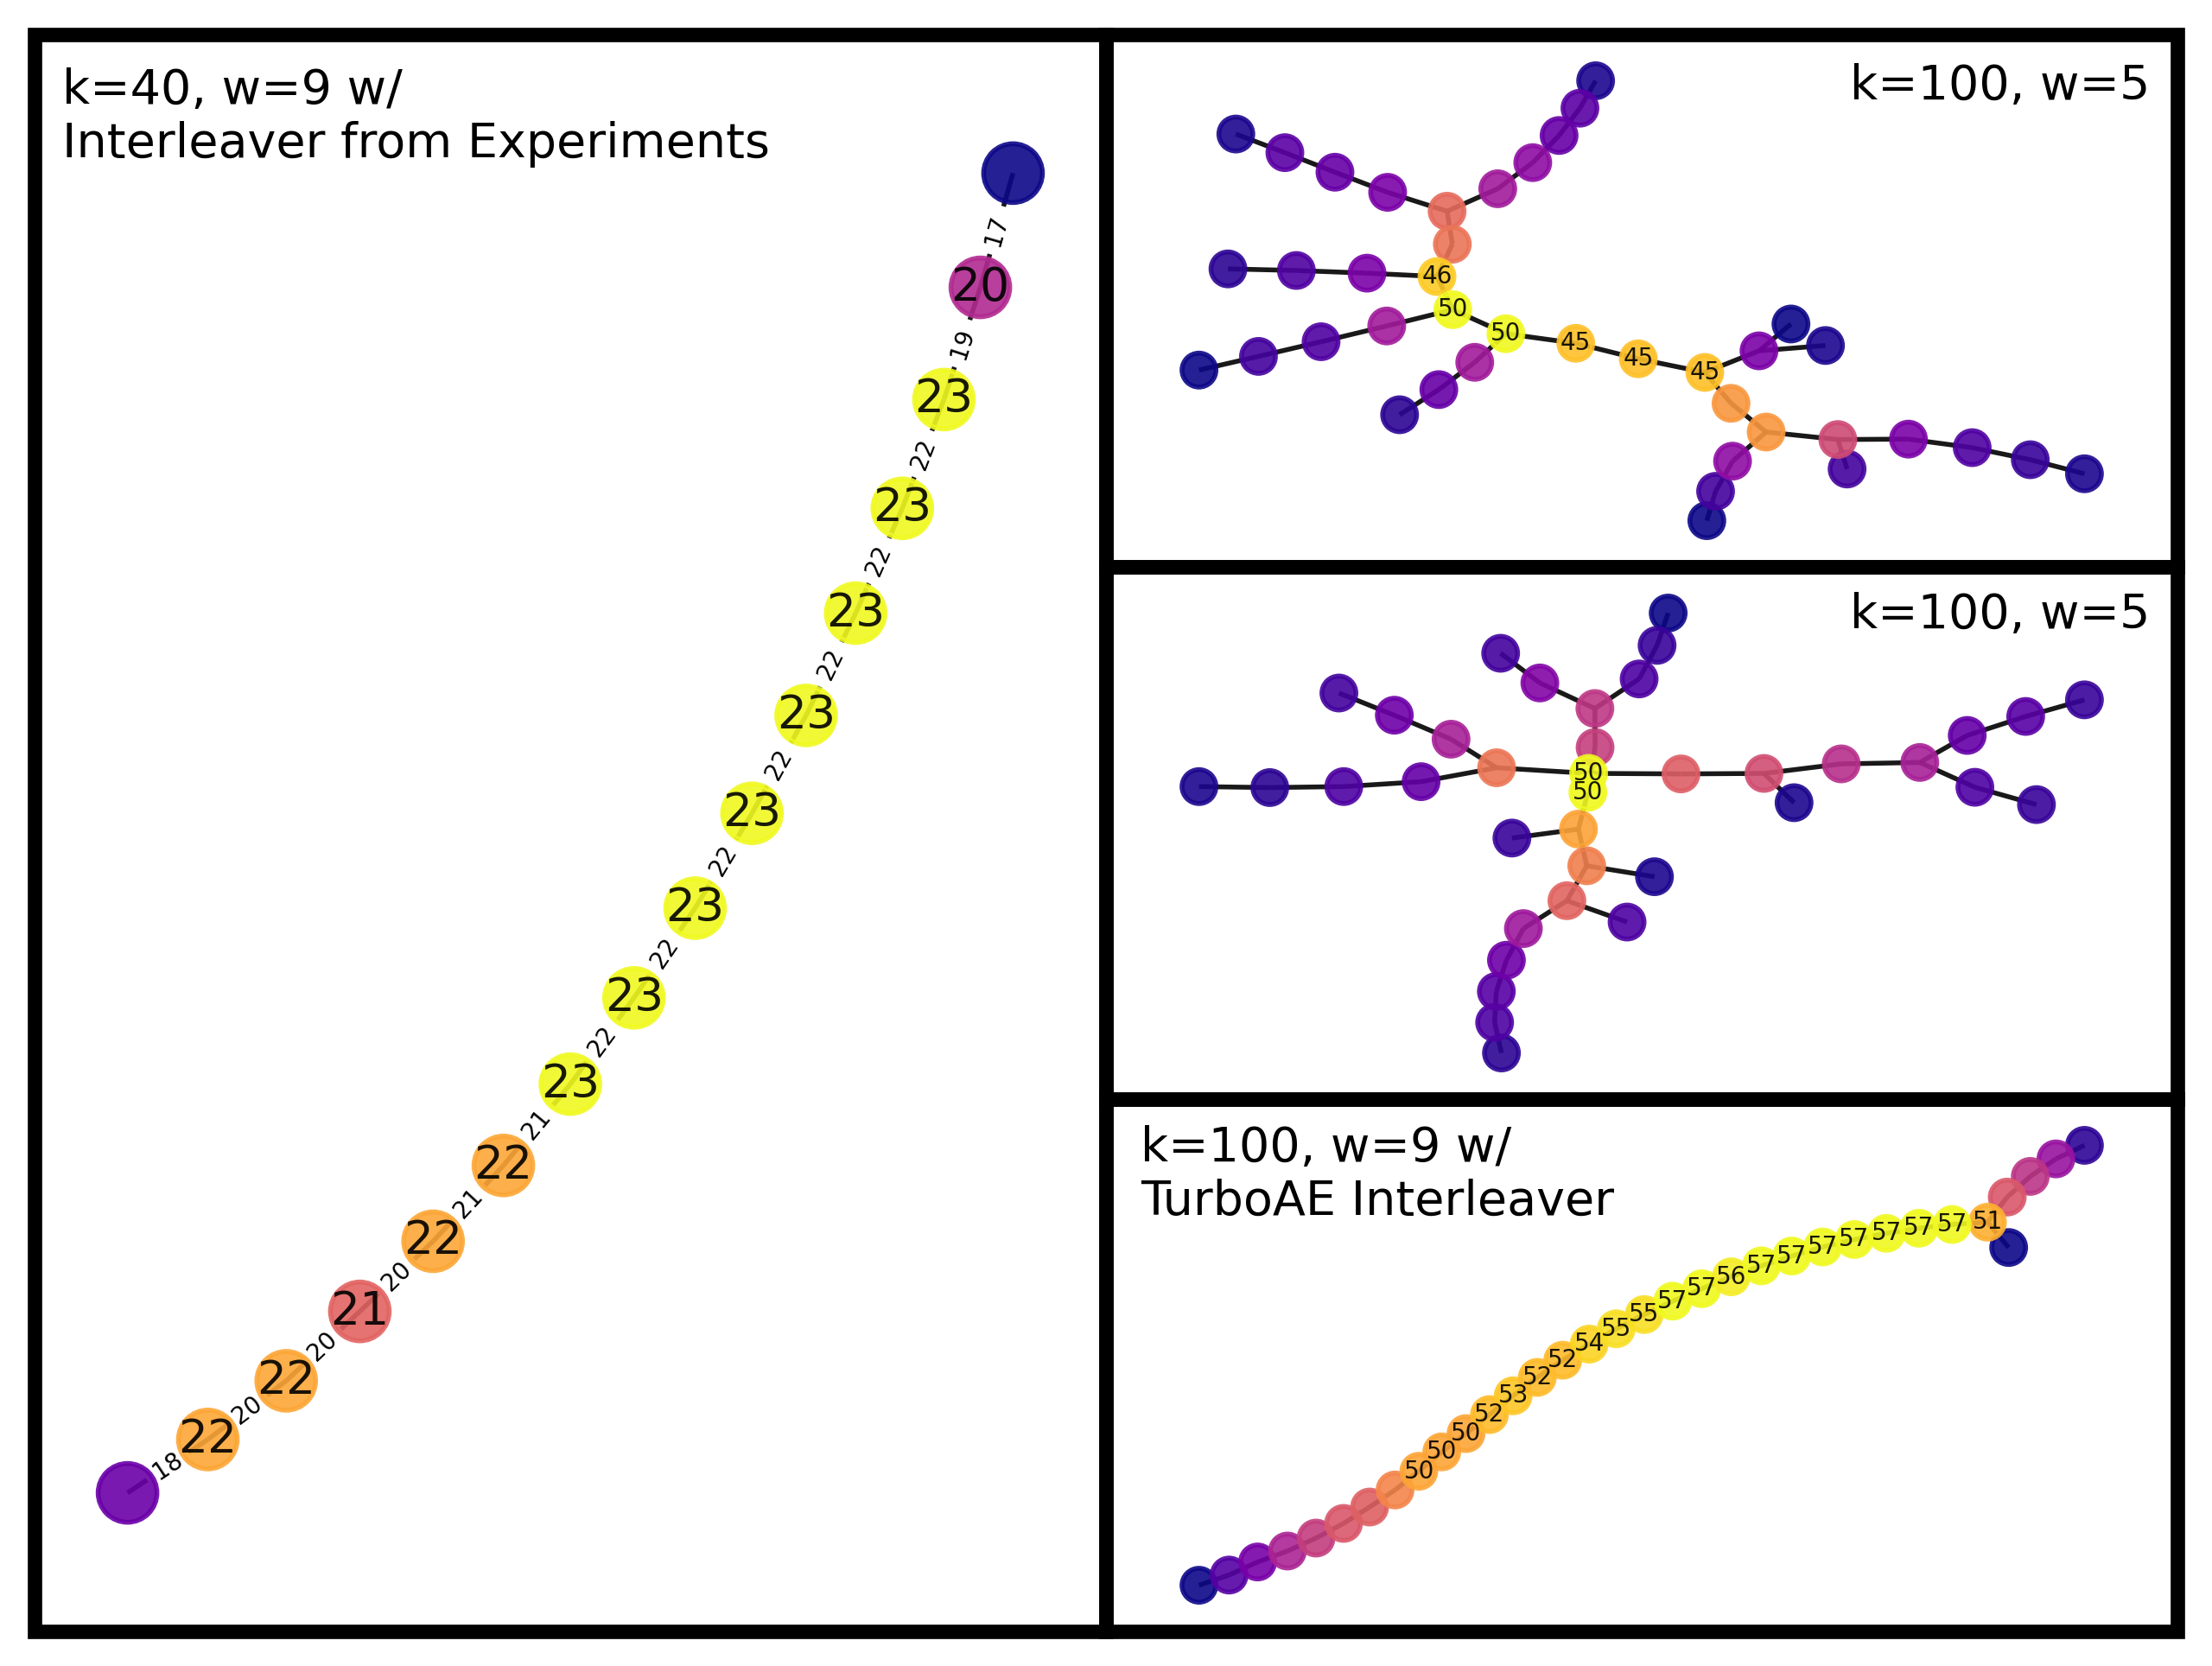

In [49]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

# ax = fig.add_axes([0.00, 0.00, 1.0, 1.0])  # Last two terms control height and width

def get_ax_bd(ax, fig):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
    # xpad = 0.05 * width
    # ypad = 0.05 * height
    xpad = 0
    ypad = 0
    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='black', linewidth=3, fill=False))

def make_nt_tree_plot(main_tree: nx.Graph, other_trees):
    fig = plt.figure(figsize=(8, 6), dpi=400)
    fig.tight_layout()
    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])
    fig.subplots_adjust(wspace=0, hspace=0)
    other_axs = [ax2, ax3, ax4]
    
    
    make_nt_tree_subplot(ax1, main_tree,node_size=150, label_edges=True, mode="neato")
    get_ax_bd(ax1, fig)
    modes = ["neato", "neato", "neato"]
    for tree, ax, mode in zip(other_trees, other_axs, modes):
        make_nt_tree_subplot(ax, tree, node_size=50, label_edges=False, mode=mode, font_size=50 * 7/70)
        get_ax_bd(ax, fig)
    
    # fig.text(x=0.95, y=0.5, s="XE\n\n", size=13, rotation=270, ha="center", va="center")
    fig.text(x=0.135, y=0.84, s="k=40, w=9 w/\nInterleaver from Experiments", size=10, rotation=0, ha="left", va="center")
    fig.text(x=0.89, y=0.855, s="k=100, w=5", size=10, rotation=0, ha="right", va="center")
    fig.text(x=0.89, y=0.6, s="k=100, w=5", size=10, rotation=0, ha="right", va="center")
    fig.text(x=0.525, y=0.33, s="k=100, w=9 w/\nTurboAE Interleaver", size=10, rotation=0, ha="left", va="center")
    
    return fig

def make_nt_tree_subplot(ax, nt_tree, node_size=300, label_edges=True, mode="dot", font_size=None):
    if font_size is None:
        font_size = node_size * 4.5/70
    pos = graphviz_layout(nt_tree, prog=mode)
    node_sizes = {node: len(nt_tree.nodes[node]["variables"]) for node in nt_tree.nodes()}
    smallest = min(node_sizes.values())
    largest = max(node_sizes.values())
    
    cmap_helper = MplColorHelper(
        "plasma", start_val=smallest, stop_val=largest
    )
    c = cmap_helper.get_rgb([node_sizes[node] for node in nt_tree])
    
    
    node_labels = {node: (node_size if node_size > 0.85 * largest else "") for node, node_size in node_sizes.items()}
    edge_labels = {edge: len(nt_tree.edges[edge]["intersection"]) for edge in nt_tree.edges()}
    
    
    nx.draw(nt_tree, pos, edge_color='black', width=1, linewidths=1,
        node_size=node_size, node_color=c, alpha=0.9, labels=node_labels, ax=ax, font_size=font_size)
    if label_edges:
        nx.draw_networkx_edge_labels(nt_tree, pos, edge_labels=edge_labels, font_size=5, ax=ax)


fig = make_nt_tree_plot(main_nt_tree, nt_trees)
fig.savefig(FIGS_DIR / f"jtree.png", bbox_inches="tight", pad_inches=0.02)

# BER vs SNR Plots

In [83]:
def annotate_benchmark_custom_turboae(data):
    for d in data:
        encoder_path = d["preamble"]["args"]["encoder_path"]
        if encoder_path == "../models/train_turboae_w9_first_no_front_small_batch_block_len_40_2_e3a1b.pt":
            encoder_plot_name = "TurboAE-40"
        elif encoder_path == "../models/train_turboae_w9_first_no_front_small_batch_block_len_40_108e8.pt":
            # encoder_plot_name = "TurboAE-40"
            raise ValueError
        d["preamble"]["args"]["encoder_plot_name"] = encoder_plot_name
    return data

def annotate_benchmark_custom_tae_jtree(data):
    for d in data:
        encoder_path = d["preamble"]["args"]["encoder_path"]
        if encoder_path == "../models/train_turboae_w9_first_no_front_small_batch_block_len_40_2_e3a1b.pt":
            encoder_plot_name = "TurboAE-40 w/ JTree"
        else:
            # encoder_plot_name = "TurboAE-40"
            raise ValueError
        d["preamble"]["args"]["encoder_plot_name"] = encoder_plot_name
    return data

def annotate_benchmark_original_turboae_jtree(data):
    for d in data:
        turboae_type = d["preamble"]["args"]["turboae_type"]
        if turboae_type == "binary":
            new_encoder_name = "TurboAE-Binary w/ JTree"
        elif turboae_type == "continuous":
            new_encoder_name = "TurboAE-Cont w/ JTree"
        else:
            raise ValueError(turboae_type)
        d["preamble"]["args"]["encoder_plot_name"] = new_encoder_name
    return data



def annotate_benchmark_original_turboae(data):
    for d in data:
        turboae_type = d["preamble"]["args"]["turboae_type"]
        if turboae_type == "binary":
            new_encoder_name = "TurboAE-Binary"
        elif turboae_type == "continuous":
            new_encoder_name = "TurboAE-Cont"
        else:
            raise ValueError(turboae_type)
        d["preamble"]["args"]["encoder_plot_name"] = new_encoder_name
    return data

def annotate_estimate_xe_bcjr(data):
    for d in data:
        original_encoder_name = d["preamble"]["args"]["encoder_name"]
        num_iter = d["preamble"]["args"]["num_iter"]
        if original_encoder_name == "turboae_binary_exact_nobd":
            # new_encoder_name = f"TurboAE-Binary w/ BCJRx{num_iter}"
            new_encoder_name = "ignore"
        elif original_encoder_name == "turboae_cont_exact_nobd":
            # new_encoder_name = f"TurboAE-Cont w/ BCJRx{num_iter}"
            new_encoder_name = "ignore"
        elif original_encoder_name == "conv_15_7_00":
            new_encoder_name = f"Turbo-155-7 w/ BCJRx{num_iter}"
        elif original_encoder_name == "conv_75_1_00":
            # new_encoder_name = f"Turbo-755-1 w/ BCJRx{num_iter}"
            new_encoder_name = "ignore"
        else:
            raise ValueError(original_encoder_name)
        d["preamble"]["args"]["encoder_plot_name"] = new_encoder_name
    return data
        
        

data_source_filepaths_to_annotator = {
    # "../data/outputs/benchmark_turboae_40.json": annotate_benchmark_custom_turboae,
    "../data/outputs/benchmark_turboae_40_2.json": annotate_benchmark_custom_turboae,
    "../data/outputs/benchmark_turboae_original_finetune_40.json": annotate_benchmark_original_turboae,
    "../data/outputs/estimate_xe_bcjr_block_len_40_turboae_cont.json": annotate_estimate_xe_bcjr,
    "../data/outputs/estimate_xe_bcjr_block_len_40.json": annotate_estimate_xe_bcjr,
    "../data/outputs/benchmark_turboae_40_2_jtree_high_snr.json": annotate_benchmark_custom_tae_jtree,
    "../data/outputs/benchmark_turboae_40_2_jtree.json": annotate_benchmark_custom_tae_jtree,
    "../data/outputs/benchmark_turboae_binary_finetuned_jtree.json": annotate_benchmark_original_turboae_jtree,
    "../data/outputs/benchmark_turboae_cont_finetuned_jtree.json": annotate_benchmark_original_turboae_jtree,
    
}

data = []
for filepath, annotator in data_source_filepaths_to_annotator.items():
    with open(filepath, "r") as f:
        exp_dict = json.load(f)
    data += annotator(exp_dict["data"])

results_df = []
for datum in data:
    if "results" in datum:
        results_df.append({**datum["results"], **datum["preamble"]["args"]})

results_df = pd.DataFrame(results_df)
results_df = results_df[results_df["num_iter"] != 20]
results_df = results_df[results_df["encoder_plot_name"] != "ignore"]
results_df.head()

,xe__mean,ber__mean,bler__mean,modulated_power__mean,modulated_mean__mean,xe__std,ber__std,bler__std,modulated_power__std,modulated_mean__std,...,interleaver_type,num_iter,patience,ce__mean,true_ber__mean,ce__std,true_ber__std,ce__err,true_ber__err,stop_tol
0,0.000172,0.000048,0.001494,1.000006,-1.794851e-05,0.002876,0.001357,0.038619,0.019120,0.091121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000438,0.000131,0.003905,1.000016,-1.174227e-05,0.005450,0.002353,0.062371,0.019122,0.091044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001062,0.000337,0.009375,0.999984,2.553165e-04,0.009078,0.004063,0.096370,0.019094,0.091163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002471,0.000784,0.020352,0.999997,5.006769e-06,0.016858,0.006523,0.141203,0.019126,0.091242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005627,0.001877,0.042748,0.999989,-9.923776e-07,0.028855,0.011973,0.202288,0.019122,0.091262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(0, 0.001, '$\\mathdefault{10^{-3}}$'), Text(0, 0.01, '$\\mathdefault{10^{-2}}$')]


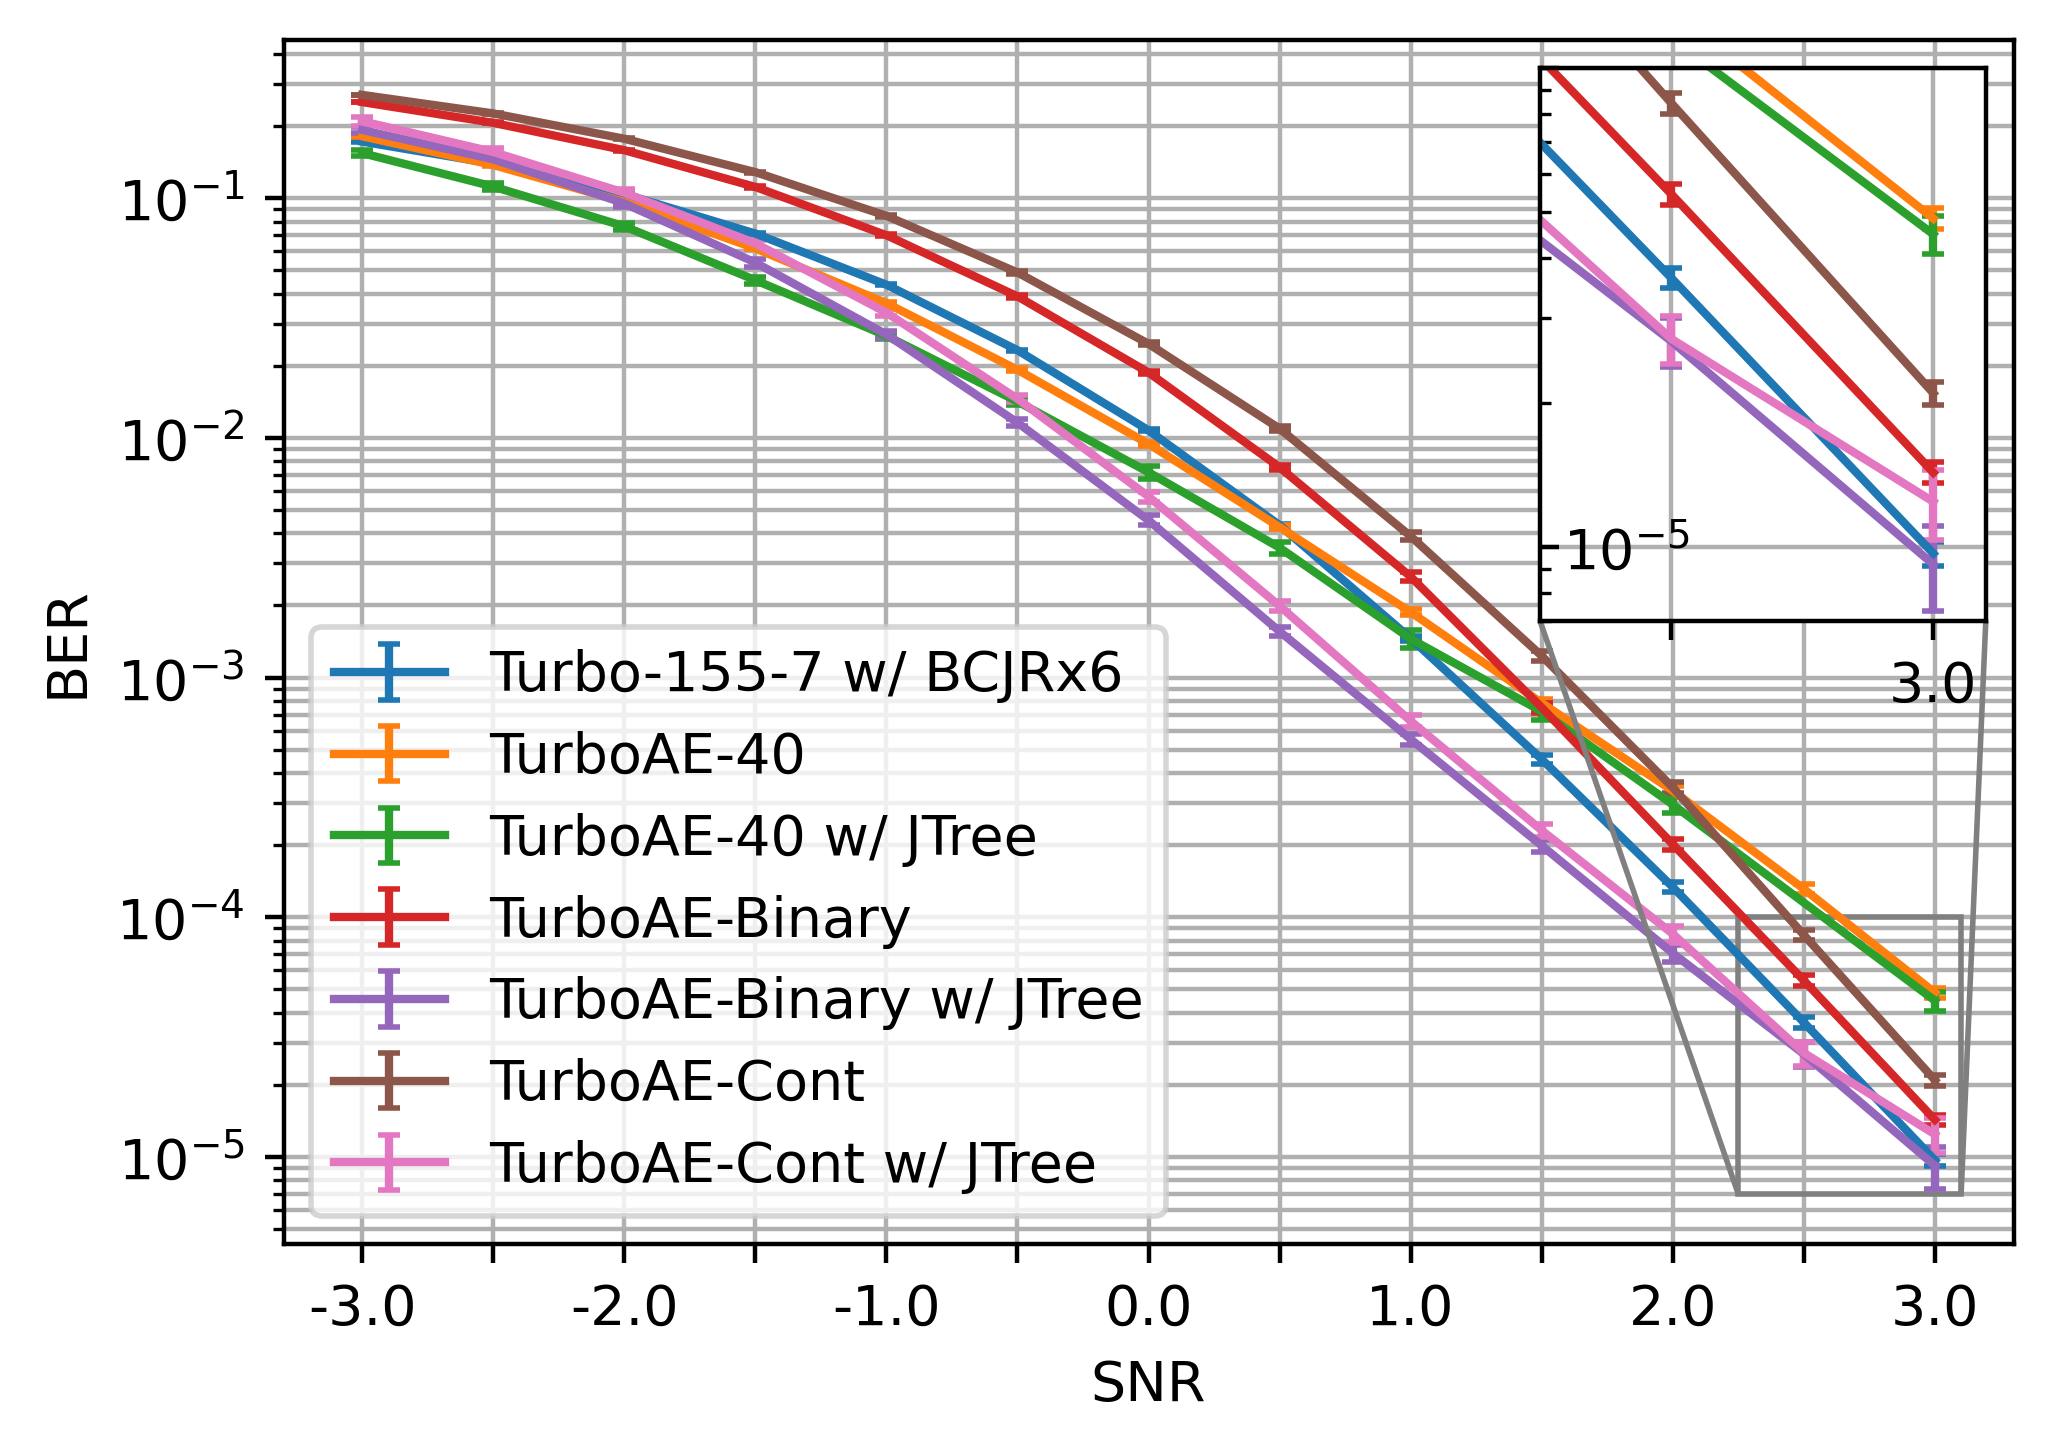

In [113]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


def plot_ber(ax, snr_df, capsize=2, show_titles=True):
    if show_titles:
        ax.set_xlabel('SNR')
        ax.set_ylabel('BER')
    
    ax.set_yscale('log')
    logfmt = mpl.ticker.LogFormatterSciNotation(base=10.0, labelOnlyBase=True)
    ax.yaxis.set_major_formatter(logfmt)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    
    ax.set_xticks(np.arange(-3.0, 4.5, 0.5))
    labeled = np.arange(-3.0, 4.5, 0.5, dtype="object")
    labeled[1::2] = None
    ax.xaxis.set_ticklabels(labeled)
    
    
    
    for encoder_plot_name, snr_result in snr_df.groupby("encoder_plot_name"):
        use_key = "ber" if snr_result["true_ber__mean"].isna().any() else "true_ber"
        ax.errorbar(
            snr_result["snr"], 
            snr_result[f"{use_key}__mean"], 
            yerr=snr_result[f"{use_key}__err"], 
            linestyle='-',
            capsize=capsize,
            label=encoder_plot_name
        )
    
def make_ber_plot(
    snr_df,
):

    fig = plt.figure(dpi=400, figsize=(5, 3.5))
    ax = fig.add_axes([0.13, 0.13, .865, .86])  # Last two terms control height and width
    capsize = 2

    plot_ber(ax, snr_df=snr_df, capsize=capsize)
    
    axins = zoomed_inset_axes(ax, 2, loc='upper right' )  # zoom = 6
    plot_ber(axins, snr_df=snr_df, capsize=capsize, show_titles=False)
    x1, x2, y1, y2 = 2.25, 3.1, 7e-6, 1e-4
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.tick_params(axis="y", direction="in", which="both")
    t = axins.yaxis.get_ticklabels()
    print(t)
    t[3].set_visible(False)
    axins.tick_params(axis="y", which="both", direction="in", pad=-27)
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    ax.grid(visible=True, which="both")
    ax.set_axisbelow(True)
    ax.legend()
    return fig

# fig.savefig(f'{channel_type}_ber_results.png')
fig = make_ber_plot(snr_df=results_df)
plt.grid()
fig.savefig("../figs/tae_40_ber_vs_snr.png", bbox_inches="tight", pad_inches=0.02)